In [1]:
#standard libraries
from pathlib import Path
from importlib import reload

#extended libraries
import requests
import rdflib
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

#tree stuff
import anytree
import anytree.util
from anytree.importer import DictImporter
from anytree.exporter import DotExporter

#custom imports
from neurondm import *
from neurondm.models.huang2017 import Genes
from pyontutils.namespaces import ilxtr as pred
from neurondm import phenotype_namespaces as phns
from pyontutils.closed_namespaces import rdf, rdfs, owl
from nifstd.nifstd_tools.utils import ncbigenemapping

#local imports
from utils import *
from tasic2015 import *

[2019-11-08 14:18:55,229] -  WARNING -       ontquery -         terms.py:239  - <class 'neurondm.core.OntTermOntologyOnly'> has intervening instrumented classes between it and its uninstrumented form <class 'neurondm.core.OntId'>
[2019-11-08 14:18:55,231] -  WARNING -       ontquery -         terms.py:239  - <class 'neurondm.core.OntTermInterLexOnly'> has intervening instrumented classes between it and its uninstrumented form <class 'neurondm.core.OntId'>
[2019-11-08 14:19:00,433] -     INFO -       neurondm -          core.py:1440 - Unknown phenotype http://jaxmice.jax.org/strain/028577
[2019-11-08 14:19:03,074] -     INFO -       neurondm -          core.py:1440 - Unknown phenotype http://www.ncbi.nlm.nih.gov/gene/14799
[2019-11-08 14:19:03,201] -     INFO -       neurondm -          core.py:1440 - Unknown phenotype http://www.ncbi.nlm.nih.gov/gene/68939
[2019-11-08 14:19:03,272] -     INFO -       neurondm -          core.py:1440 - Unknown phenotype http://www.ncbi.nlm.nih.gov/gene/

In [2]:
%load_ext autoreload
%autoreload 1
%aimport tasic2015

In [3]:
def cellguard(addns=False):
    # unfortunately ipy.hooks['pre_run_code_hook'].add(__cellguard)
    # causes this to be called too frequently :/
    setLocalNames()
    setLocalContext()
    if addns:
        setLocalNames(phns.BBP)

### Processed Tables (original)

In [11]:
df_clf.head(3)  #cluster membership
#TODO: Only including unambiguous cells with f-values = 10 for one cluster only.

,cell_index,coretype,primary,secondary
0,A200_V,Core,f01,0
1,A201_V,Core,f02,0
2,A202_V,Core,f24,0


In [12]:
df_cls_mtd.head(3)  #cluster metadata

,cluster_id,cluster_order,vignette_label,group,markers_present,markers_sparse,genes_absent,Tasic_et_al_2016_label
0,f01,7,Vip Mybpc1,Vip,"Crispld2, Cxcl14, Tpm2, Itih5, Cox6a2",Tmem182,"Npy2r, Sorl1, Car4",Vip Mybpc1
1,f02,6,Vip Cxcl14_Car4,Vip,"Cxcl14, Car4, Tac2","Dmp1, Syt10","Mybpc1, Npy2r, Slc44a5",Vip Parm1
2,f03,8,Vip Sncg,Vip,"Reln, Npy2r, Tnfaip8l3, Cadps2, 2310042E22Rik,...","Casq2, Edn3",NaN,Vip Sncg


In [13]:
df_cell_mtd.head(3)  #cre and layer

,short_name,cre,major_class,sub_class,major_dissection,layer_dissectoin
0,A200_V,Calb2,Inhibitory,Vip,V1,All
1,A201_V,Calb2,Inhibitory,Vip,V1,All
2,A202_V,Calb2,Excitatory,L4,V1,All


In [14]:
df_cre_mtd.head(3)  #cre line metadata

,#,Driver Line,Abbreviation,Originating Lab (Donating Investigator),Primary Reference,Generation Method,"Generation Method, more detail",Public Repository,Public Repository Stock #,Repository Strain Name,Data available through the Allen Institute Transgenic Portal
0,1.0,Calb2-IRES-Cre,Calb2,Z. Josh Huang,"Taniguchi et al., Neuron 2011",Knock-in,IRES,The Jackson Laboratory,10774.0,B6(Cg)-Calb2tm1(cre)Zjh/J,http://connectivity.brain-map.org/transgenic/s...
1,2.0,Chat-IRES-Cre,Chat,Brad Lowell,"Rossi et al., Cell Metab. 2011",Knock-in,IRES,The Jackson Laboratory,6410.0,B6;129S6-Chattm1(cre)Lowl/J,http://connectivity.brain-map.org/transgenic/s...
2,3.0,Chrna2-Cre_OE25,Chrna2,Nathaniel Heintz and Charles Gerfen,"Gerfen et al., Neuron 2013",Transgenic,BAC,MMRRC,36502.0,STOCK Tg(Chrna2-cre)OE25Gsat/Mmucd,http://connectivity.brain-map.org/transgenic/s...


### Final Versions (merged)

In [9]:
#final combined table for cluster, layer, & cre
df_types.head(3)

,short_name,coretype,primary,secondary,cre,major_dissection,layer_dissectoin,cluster,markers_present,markers_absent
0,A200_V,Core,f01,0,Calb2,V1,All,81,"{ Tpm2, Cox6a2, Cxcl14, Itih5, Crispld2}","{Npy2r, Sorl1, Car4}"
1,A201_V,Core,f02,0,Calb2,V1,All,80,"{ Car4, Tac2, Cxcl14}","{ Npy2r, Slc44a5, Mybpc1}"
2,A202_V,Core,f24,0,Calb2,V1,All,70,"{ Inhba, Pde1a, Rspo1, Rorb, Lmo3, Whrn, ...","{ Kitl, Scnn1a, Endou, Fam19a1}"


In [15]:
cre_df.head(3)

,Abbreviation,name,id,stock_number,transgenic_line_source_name,transgenic_line_type_name,url_prefix,url_suffix,description
0,Calb2,Calb2-IRES-Cre,177837281,10774.0,JAX,driver,http://jaxmice.jax.org/strain/,.html,Enriched in restricted populations within the ...
1,Chrna2,Chrna2-Cre_OE25,182693192,36502.0,MMRRC,driver,http://www.mmrrc.org/catalog/getSDS.jsp?mmrrc_id=,None,Enriched in cortical layer 5. Also expressed i...
2,Cux2,Cux2-CreERT2,177839004,32779.0,MMRRC,driver,http://www.mmrrc.org/catalog/getSDS.jsp?mmrrc_id=,None,"Enriched in cortical layers 2/3/4, thalamus, m..."


### Data Visualization

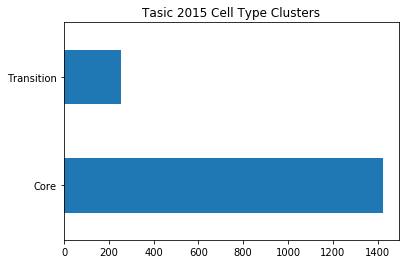

In [16]:
pd.value_counts(df_types['coretype']).plot.barh();
plt.title("Tasic 2015 Cell Type Clusters");

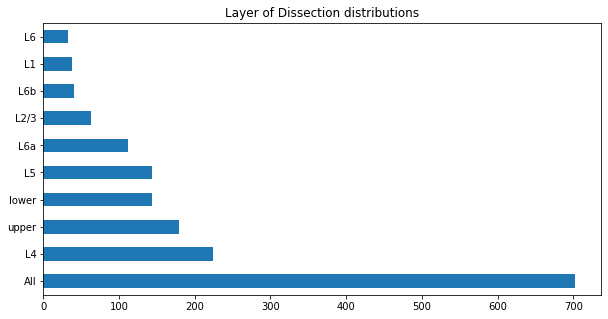

In [17]:
pd.value_counts(df_types['layer_dissectoin']).plot.barh(figsize = (10,5));
plt.title("Layer of Dissection distributions");

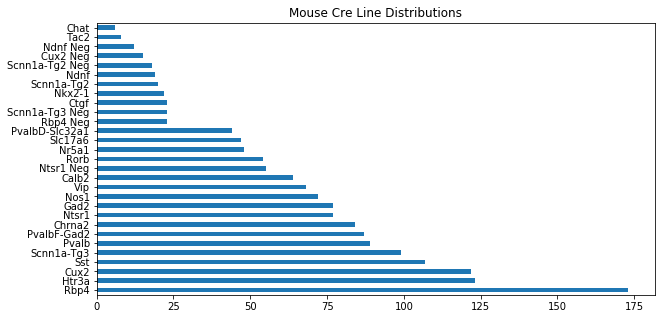

In [18]:
pd.value_counts(df_types['cre']).plot.barh(figsize = (10,5));
plt.title("Mouse Cre Line Distributions");

In [40]:
# FIX: many from df_types['cre'] are missing in cre_df
diff(df_types['cre'].value_counts().keys(), cre_df['Abbreviation'].tolist(), symmetric = False)

['Scnn1a-Tg3 Neg',
 'Cux2 Neg',
 'PvalbD-Slc32a1',
 'PvalbF-Gad2',
 'Rbp4 Neg',
 'Tac2',
 'Scnn1a-Tg2 Neg',
 'Nkx2-1',
 'Ndnf Neg',
 'Ntsr1 Neg',
 'Ctgf']

In [33]:
sorted(cre_ref['name'].tolist())

['A930038C07Rik-Tg1-Cre',
 'A930038C07Rik-Tg4-Cre',
 'Adcyap1-2A-Cre',
 'Agrp-IRES-Cre',
 'Ai110(RCL-FnGF-nT)',
 'Ai136(TITL-ReaChR-YFP)',
 'Ai139(TIT2L-GFP-ICL-TPT)',
 'Ai14(RCL-tdT)',
 'Ai140(TIT2L-GFP-ICL-tTA2)',
 'Ai148(TIT2L-GC6f-ICL-tTA2)',
 'Ai148(TIT2L-GC6f-ICL-tTA2)-hyg',
 'Ai162(TIT2L-GC6s-ICL-tTA2)',
 'Ai2',
 'Ai27',
 'Ai3',
 'Ai31',
 'Ai32(RCL-ChR2(H134R)_EYFP)',
 'Ai34',
 'Ai35(RCL-Arch_GFP)',
 'Ai38',
 'Ai39',
 'Ai40',
 'Ai47',
 'Ai57(RCL-Jaws)',
 'Ai6',
 'Ai62(TITL-tdT)',
 'Ai63(TIT-tdT)',
 'Ai65(RCFL-tdT)',
 'Ai65F',
 'Ai66(RCRL-tdT)',
 'Ai75(RCL-nT)',
 'Ai78(TITL-VSFPB)',
 'Ai79(TITL-Jaws)',
 'Ai82(TITL-GFP)',
 'Ai85(TITL-iGluSnFr)',
 'Ai86(TITL-ArcLight)',
 'Ai87(RCL-iGluSnFR)',
 'Ai9',
 'Ai90(TITL-Chronos)',
 'Ai92(TITL-YCX2.60)',
 'Ai93(TITL-GCaMP6f)',
 'Ai93(TITL-GCaMP6f)-STOPdel',
 'Ai93(TITL-GCaMP6f)-hyg',
 'Ai94(TITL-GCaMP6s)',
 'Ai95(RCL-GCaMP6f)',
 'Ai96(RCL-GCaMP6s)-neo',
 'Avp-IRES2-Cre',
 'Calb1-IRES2-Cre',
 'Calb1-IRES2-Cre-neo',
 'Calb1-T2A-dgCre',
 'Calb

In [28]:
cre_ref

,description,id,name,originating_lab,stock_number,sub_image_annotation_id,transgenic_line_source_name,transgenic_line_type_code,transgenic_line_type_name,url_prefix,url_suffix
0,Cre expression is enriched in cortical layers ...,177835668,Cux2-Cre,Ulrich Mueller,32778.0,21886.0,MMRRC,D,driver,http://www.mmrrc.org/catalog/getSDS.jsp?mmrrc_id=,None
1,"Cre expression is enriched in layers 2/3, and ...",306000233,Plxnd1-CreER,Z. Josh Huang,NaN,543091192.0,Other,D,driver,None,None
2,Scattered expression in cortical and subcortic...,617166869,Tacr1-T2A-Cre-neo,Allen Institute for Brain Science,NaN,623914828.0,AIBS,D,driver,None,None
3,"Widespread, scattered expression throughout br...",177838193,Et(cre/ERT2)6959Rdav,Ronald L. Davis and Paul A. Overbeek,10689.0,21928.0,JAX,D,driver,http://jaxmice.jax.org/strain/,.html
4,None,561404352,PhiC31-neo,None,NaN,NaN,None,D,driver,None,None
...,...,...,...,...,...,...,...,...,...,...,...
308,Reporter expression is enriched in layers 2/3 ...,287226763,Calb1-T2A-dgCre,Allen Institute for Brain Science,23531.0,471682394.0,JAX,D,driver,http://jaxmice.jax.org/strain/,.html
309,Scattered expression in restricted populations...,177837320,Camk2a-tTA,Mark Mayford and Ulrich Mueller,31781.0,178398161.0,MMRRC,D,driver,http://www.mmrrc.org/catalog/getSDS.jsp?mmrrc_id=,None
310,"Widespread, scattered expression throughout br...",177838209,Et(icre)1555Rdav,Ronald L. Davis and Paul A. Overbeek,9589.0,21917.0,JAX,D,driver,http://jaxmice.jax.org/strain/,.html
311,Strong expression in the zonal layer of the su...,179697864,Rorb-IRES2-Cre,Allen Institute for Brain Science,23526.0,263635668.0,JAX,D,driver,http://jaxmice.jax.org/strain/,.html


In [22]:
df_cre_mtd

,#,Driver Line,Abbreviation,Originating Lab (Donating Investigator),Primary Reference,Generation Method,"Generation Method, more detail",Public Repository,Public Repository Stock #,Repository Strain Name,Data available through the Allen Institute Transgenic Portal
0,1.0,Calb2-IRES-Cre,Calb2,Z. Josh Huang,"Taniguchi et al., Neuron 2011",Knock-in,IRES,The Jackson Laboratory,10774.0,B6(Cg)-Calb2tm1(cre)Zjh/J,http://connectivity.brain-map.org/transgenic/s...
1,2.0,Chat-IRES-Cre,Chat,Brad Lowell,"Rossi et al., Cell Metab. 2011",Knock-in,IRES,The Jackson Laboratory,6410.0,B6;129S6-Chattm1(cre)Lowl/J,http://connectivity.brain-map.org/transgenic/s...
2,3.0,Chrna2-Cre_OE25,Chrna2,Nathaniel Heintz and Charles Gerfen,"Gerfen et al., Neuron 2013",Transgenic,BAC,MMRRC,36502.0,STOCK Tg(Chrna2-cre)OE25Gsat/Mmucd,http://connectivity.brain-map.org/transgenic/s...
3,4.0,Ctgf-2A-dgCre,Ctgf,Allen Institute for Brain Science,This paper,Knock-in,T2A,NaN,NaN,NaN,http://connectivity.brain-map.org/transgenic/s...
4,5.0,Cux2-CreERT2,Cux2,Ulrich Mueller,"Franco et al., Science 2012",Knock-in,Direct,MMRRC,32779.0,B6(Cg)-Cux2<tm3.1(cre/ERT2)Mull>/Mmmh,http://connectivity.brain-map.org/transgenic/s...
5,6.0,Gad2-IRES-Cre,Gad2,Z. Josh Huang,"Taniguchi et al., Neuron 2011",Knock-in,IRES,The Jackson Laboratory,10802.0,STOCK Gad2tm2(cre)Zjh/J,http://connectivity.brain-map.org/transgenic/s...
6,7.0,Htr3a-Cre_NO152,Htr3a,Nathaniel Heintz and Charles Gerfen,"Gerfen et al., Neuron 2013",Transgenic,BAC,MMRRC,36680.0,STOCK Tg(Htr3a-cre)NO152Gsat/Mmucd,http://connectivity.brain-map.org/transgenic/s...
7,8.0,Ndnf-IRES2-dgCre,Ndnf,Allen Institute for Brain Science,This paper,Knock-in,IRES2,NaN,NaN,NaN,http://connectivity.brain-map.org/transgenic/s...
8,9.0,Nkx2.1-CreERT2,Nkx2.1,Z. Josh Huang,"Taniguchi et al., Science 2013",Knock-in,Direct,The Jackson Laboratory,14552.0,STOCK Nkx2-1tm1.1(cre/ERT2)Zjh/J,http://connectivity.brain-map.org/transgenic/s...
9,10.0,Nos1-CreERT2,Nos1,Z. Josh Huang,"Taniguchi et al., Neuron 2011",Knock-in,Direct,The Jackson Laboratory,14541.0,B6;129S-Nos1tm1.1(cre/ERT2)Zjh/J,http://connectivity.brain-map.org/transgenic/s...


In [21]:
df_cre_mtd[df_cre_mtd['Abbreviation'] == 'Nkx2-1']

,#,Driver Line,Abbreviation,Originating Lab (Donating Investigator),Primary Reference,Generation Method,"Generation Method, more detail",Public Repository,Public Repository Stock #,Repository Strain Name,Data available through the Allen Institute Transgenic Portal


In [10]:
string = "a bird hit a rock"
if "rock" in string.strip():
    print('True')

True


In [8]:
diff??

In [6]:
cre_df.head()

,Abbreviation,name,id,stock_number,transgenic_line_source_name,transgenic_line_type_name,url_prefix,url_suffix,description
0,Calb2,Calb2-IRES-Cre,177837281,10774.0,JAX,driver,http://jaxmice.jax.org/strain/,.html,Enriched in restricted populations within the ...
1,Chrna2,Chrna2-Cre_OE25,182693192,36502.0,MMRRC,driver,http://www.mmrrc.org/catalog/getSDS.jsp?mmrrc_id=,None,Enriched in cortical layer 5. Also expressed i...
2,Cux2,Cux2-CreERT2,177839004,32779.0,MMRRC,driver,http://www.mmrrc.org/catalog/getSDS.jsp?mmrrc_id=,None,"Enriched in cortical layers 2/3/4, thalamus, m..."
3,Gad2,Gad2-IRES-Cre,177838584,10802.0,JAX,driver,http://jaxmice.jax.org/strain/,.html,Specific to GABAergic neurons. Enriched in the...
4,Htr3a,Htr3a-Cre_NO152,298341195,36680.0,MMRRC,driver,http://www.mmrrc.org/catalog/getSDS.jsp?mmrrc_id=,None,Reporter expression is detected in a subset of...


## Writing & Serializing

In [23]:
ttl_test_path = '/var/host/media/removable/SD Card/Neuron/Tasic/ttl_export'
config = Config("tasic-2015", ttl_export_dir=Path(ttl_test_path))
tb = TasicBagger(data = df_types, **metadata)
ind = 0
for label, bag in tb.bags:
    if ind == 1:
        break
    TasicNeuron(*bag, label = label, override=True)
    ind += 1
config.write()
config.write_python()

NameError: name 'metadata' is not defined

In [ ]:
from neurondm.sheets import Sheet
from neurondm import OntId, OntTerm, Config, NeuronEBM, Neuron
from pyontutils.utils import byCol, relative_path
from pyontutils.namespaces import ilxtr
from pyontutils.closed_namespaces import rdfs

main()

In [ ]:
metadata = {"cre":cre_df}
tb = TasicBagger(data = df_types, **metadata)
tb.build_transgenic_lines()

### Test Code

In [ ]:
# metada query test
df_cre_mtd[df_cre_mtd['Abbreviation'] == df_types['cre'][12]]

In [ ]:
def main():
    metadata = {"cre": cre_df}
    ttl_test_path = '/mnt/c/Users/allen/Desktop/Neuron/Tasic2015/ttl_export'
    config = Config("tasic-2015", ttl_export_dir=Path(ttl_test_path))
    tb = TasicBagger(data=df_types, **metadata)
    ind = 0
    for label, bag in tb.bags:
        if ind == 10:
            break
        TasicNeuron(*bag, label=label, override=True)
        ind += 1
    config.write()

In [41]:
with Tasic2015:
    print(Mouse)

Phenotype('NCBITaxon:10090',
          'ilxtr:hasInstanceInTaxon',
          label='Mus musculus')


In [46]:
ncbigenemapping??

In [ ]:
Phenotype("ilxtr:cluster6", "ilxtr:hasComputedMolecularPhenotype", label = "Tasic2015", check = False)

In [55]:
ttl_test_path = '/mnt/c/Users/allen/Desktop/Neuron/Tasic2015/ttl_export'
config = Config("tasic-2015", ttl_export_dir=Path(ttl_test_path))
with Neuron(phns.Species.Mouse, phns.Regions.V1) as context:
    print(context)
    n11 = Neuron(TasicBagger.layer_parse(df_types['layer_dissectoin'][0]))
    print(n11)
config.write()

[2019-10-11 10:42:46,699] -  WARNING -       neurondm -          core.py:1082 - Warning local base has been set manually you are on your own!
[2019-10-11 10:42:48,601] -    DEBUG -       neurondm -          core.py:2914 - All


Neuron(Phenotype('NCBITaxon:10090',
                 'ilxtr:hasInstanceInTaxon',
                 label='Mus musculus'),
       Phenotype('UBERON:0002436',
                 'ilxtr:hasSomaLocatedIn',
                 label='primary visual cortex'))
Neuron(Phenotype('NCBITaxon:10090',
                 'ilxtr:hasInstanceInTaxon',
                 label='Mus musculus'),
       Phenotype('UBERON:0002436',
                 'ilxtr:hasSomaLocatedIn',
                 label='primary visual cortex'),
       LogicalPhenotype(OR,
                        LogicalPhenotype(OR,
                                         Phenotype('UBERON:0005390',
                                                   'ilxtr:hasSomaLocatedInLayer',
                                                   label='cortical layer I'),
                                         Phenotype('UBERON:0005391',
                                                   'ilxtr:hasSomaLocatedInLayer',
                                                   

In [ ]:
mapping, to_add, errors = ncbigenemapping()